In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from EvolutionTree import EvolutionTree
import os
import pymc as pm
import arviz as az

## To Do:
1. number different among different leaf nodes.
2. more than one evolution tree

### Check Tree

True values at all nodes: [-0.45802699 -0.00341632 -0.89628902  0.75179844  0.87140645 -0.91082826
 -1.16294867  1.94592909  0.18841549  0.27748984  2.61091597  1.14808382
 -1.07528667 -1.68144248 -1.07529355]
Observed values at leaves: [ 1.94592909  0.18841549  0.27748984  2.61091597  1.14808382 -1.07528667
 -1.68144248 -1.07529355]


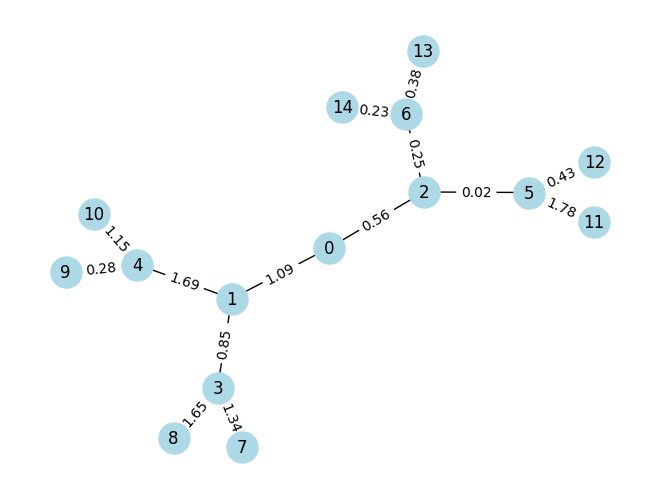

In [2]:
np.random.seed(100)
tree = EvolutionTree(depth=3, sigma_0=1.0, sigma=1.0, delta=0.1)
X, X_obs, leaves = tree.generate_data()
print("True values at all nodes:", X)
print("Observed values at leaves:", X_obs)

tree.plot_tree()

In [3]:
tree.validate_covariance()

Covariance between leaf 7 and leaf 7: 4.290956518361085
Covariance between leaf 7 and leaf 8: 2.946165839754796
Covariance between leaf 7 and leaf 9: 2.091375834164021
Covariance between leaf 7 and leaf 10: 2.091375834164021
Covariance between leaf 7 and leaf 11: 1.0
Covariance between leaf 7 and leaf 12: 1.0
Covariance between leaf 7 and leaf 13: 1.0
Covariance between leaf 7 and leaf 14: 1.0
Covariance between leaf 8 and leaf 8: 4.599612822413841
Covariance between leaf 8 and leaf 9: 2.091375834164021
Covariance between leaf 8 and leaf 10: 2.091375834164021
Covariance between leaf 8 and leaf 11: 1.0
Covariance between leaf 8 and leaf 12: 1.0
Covariance between leaf 8 and leaf 13: 1.0
Covariance between leaf 8 and leaf 14: 1.0
Covariance between leaf 9 and leaf 9: 4.064526450953686
Covariance between leaf 9 and leaf 10: 3.7824803374806297
Covariance between leaf 9 and leaf 11: 1.0
Covariance between leaf 9 and leaf 12: 1.0
Covariance between leaf 9 and leaf 13: 1.0
Covariance between 

### MCMC

In [4]:
# Generate multiple Y_obs samples for more robust inference
delta = 0.1  # Observation noise variance
tree = EvolutionTree(depth=3, sigma_0=0.1, sigma=5, delta=delta)
X, X_obs, leaves = tree.generate_data()

T = 60  # Number of time steps for observations
### different leaf may have different observation number
Y_obs_list = np.array([X_obs + np.random.normal(0, delta, size=X_obs.shape) for _ in range(T)])  # (T, leaf) size matrix
# print("True values at nodes:", X)
# print("Observed values at leaves (multiple samples):", Y_obs_list)

In [5]:
print(Y_obs_list.shape)

(60, 8)


In [6]:
# Inference with PyMC
with pm.Model() as model:
    # Priors for the parameters
    sigma_0 = pm.InverseGamma("sigma_0", alpha=3.0, beta=1)
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=1)
    
    # sigma_0 = pm.HalfNormal("sigma_0", sigma=1)
    # sigma = pm.HalfNormal("sigma", sigma=1)
    delta = pm.HalfNormal("delta", sigma=1.0)
    
    # Define the covariance matrix for the leaf nodes
    cov_matrix_elements = []
    for i in range(len(leaves)):
        row = []
        for j in range(len(leaves)):
            lca = tree.find_lowest_common_ancestor(leaves[i], leaves[j])
            path_to_lca = nx.shortest_path(tree.tree, source=0, target=lca)
            covariance = sigma_0**2 + sigma**2 * sum(tree.branch_lengths[(path_to_lca[k], path_to_lca[k + 1])] for k in range(len(path_to_lca) - 1))
            row.append(covariance)
        cov_matrix_elements.append(row)
        cov_matrix = pm.math.stack([pm.math.stack(row) for row in cov_matrix_elements])
    # Generate the mean vector for leaf nodes (zero mean assumed)
    mu_prior = pm.math.zeros(len(leaves))
    mu = pm.MvNormal("mu", mu=mu_prior, cov=cov_matrix, shape=(len(leaves),))
    # Multivariate normal likelihood for observed data
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=delta, observed=Y_obs_list)

    # Sampling
    trace = pm.sample(1000, return_inferencedata=True, tune=300, chains = 4)

Auto-assigning NUTS sampler...
/Users/xumin/Desktop/SI_618/si618wn23-main/.conda/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_0, sigma, delta, mu]
/Users/xumin/Desktop/SI_618/si618wn23-main/.conda/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(
/Users/xumin/Desktop/SI_618/si618wn23-main/.conda/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(
/Users/xumin/Desktop/SI_618/si618wn23-main/.conda/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnin

Output()

/Users/xumin/Desktop/SI_618/si618wn23-main/.conda/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(


Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 20 seconds.


Posterior values:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta     0.109  0.003   0.103    0.116      0.000    0.000    7085.0   
mu[0]   -15.347  0.014 -15.374  -15.320      0.000    0.000    7868.0   
mu[1]    -2.680  0.014  -2.707   -2.654      0.000    0.000    7963.0   
mu[2]    -1.635  0.014  -1.659   -1.607      0.000    0.000    6599.0   
mu[3]    -4.239  0.014  -4.264   -4.211      0.000    0.000    6308.0   
mu[4]    13.809  0.014  13.783   13.835      0.000    0.000    6737.0   
mu[5]     2.302  0.014   2.276    2.329      0.000    0.000    6619.0   
mu[6]    -7.568  0.014  -7.593   -7.541      0.000    0.000    7099.0   
mu[7]   -20.652  0.014 -20.680  -20.626      0.000    0.000    7491.0   
sigma     6.140  1.442   3.912    8.856      0.021    0.017    6939.0   
sigma_0   0.515  0.540   0.104    1.176      0.010    0.007    7157.0   

         ess_tail  r_hat  
delta      3127.0    1.0  
mu[0]      3054.0    1.0  
mu[1]      2860.0    1.0

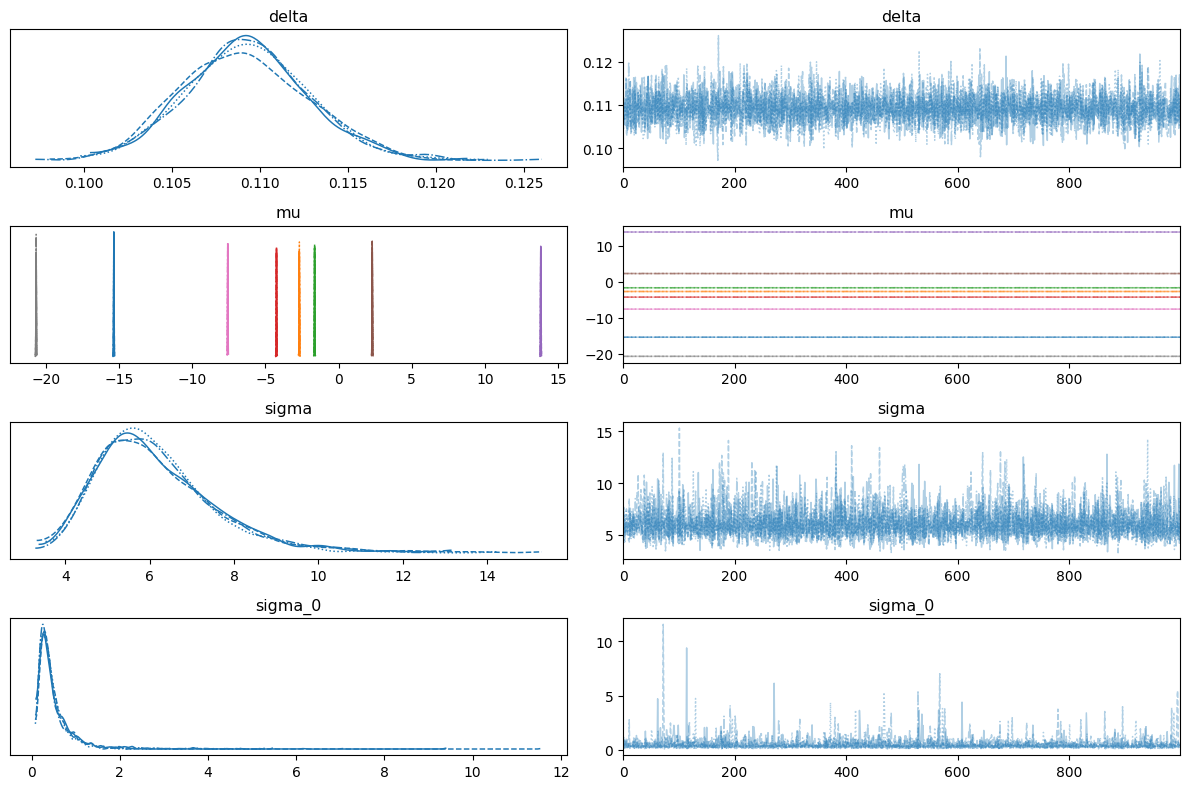

In [7]:
# Display and save posterior values
print("Posterior values:")
print(az.summary(trace))
az.to_netcdf(trace, 'posterior_trace.nc')        
# Posterior analysis
az.plot_trace(trace, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [8]:
with model:
    # Extract and save posterior means for all parameters
    posterior_delta = trace.posterior['delta'].mean(dim=['chain', 'draw']).values
    posterior_sigma = trace.posterior['sigma'].mean(dim=['chain', 'draw']).values
    posterior_sigma_0 = trace.posterior['sigma_0'].mean(dim=['chain', 'draw']).values
    posterior_X = trace.posterior['mu'].mean(dim=['chain', 'draw']).values

    # Save posterior means to a dictionary
    posterior_means = {
        'delta': posterior_delta,
        'sigma': posterior_sigma,
        'sigma_0': posterior_sigma_0,
        'X_prior': posterior_X
    }

In [9]:
posterior_means

{'delta': array(0.10923598),
 'sigma': array(6.13953697),
 'sigma_0': array(0.51543229),
 'X_prior': array([-15.34743135,  -2.67976281,  -1.63455935,  -4.23904607,
         13.80862258,   2.30244418,  -7.56766867, -20.65245857])}

In [10]:
Ground_truth = {
        'delta': 0.1,
        'sigma': tree.sigma,
        'sigma_0': tree.sigma_0,
        'X_prior': X_obs
    }

In [11]:
Ground_truth

{'delta': 0.1,
 'sigma': 5,
 'sigma_0': 0.1,
 'X_prior': array([-15.34622217,  -2.68491762,  -1.64063454,  -4.23900152,
         13.78996622,   2.31640326,  -7.58006007, -20.6503995 ])}

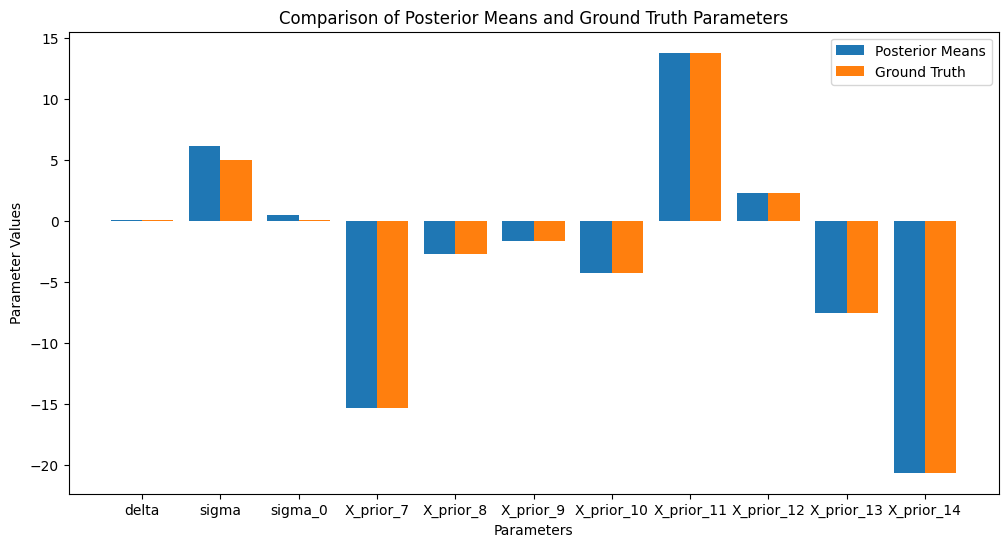

In [12]:
# Extracting parameter names and values
parameters = list(posterior_means.keys())
posterior_values = []
ground_truth_values = []

for param in parameters:
    if param == 'X_prior':
        posterior_values.extend(posterior_means[param])
        ground_truth_values.extend(Ground_truth[param])
    else:
        posterior_values.append(posterior_means[param])
        ground_truth_values.append(Ground_truth[param])

# Update parameters list to reflect individual X_prior components
parameters = [param for param in parameters if param != 'X_prior'] + [f'X_prior_{leaves[i]}' for i in range(len(posterior_X)) ]

# Plotting the bar chart for comparison
indices = np.arange(len(parameters))  # the label locations
width = 0.4  # the width of the bars

plt.figure(figsize=(12, 6))
plt.bar(indices - width/2, posterior_values, width=width, label='Posterior Means')
plt.bar(indices + width/2, ground_truth_values, width=width, label='Ground Truth')
plt.ylabel('Parameter Values')
plt.xlabel('Parameters')
plt.title('Comparison of Posterior Means and Ground Truth Parameters')
plt.xticks(np.arange(len(posterior_values)), parameters)
plt.legend()
plt.show()

In [13]:
tree.X_obs

array([-15.34622217,  -2.68491762,  -1.64063454,  -4.23900152,
        13.78996622,   2.31640326,  -7.58006007, -20.6503995 ])

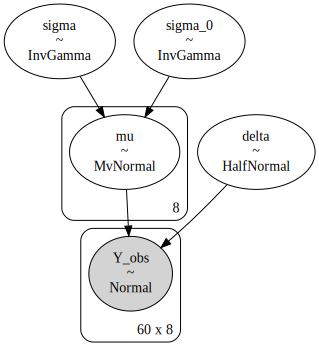

In [14]:
pm.model_to_graphviz(model)

### Evaluation

In [15]:
# Define a function to compute the joint logarithmic likelihood
delta = 0.1
def calculate_joint_log_likelihood(X, sigma_0, sigma, delta, Y_obs_list, tree, leaves):

    cov_matrix = np.zeros((len(leaves), len(leaves)))
    for i in range(len(leaves)):
        for j in range(len(leaves)):
            lca = tree.find_lowest_common_ancestor(leaves[i], leaves[j])
            path_to_lca = nx.shortest_path(tree.tree, source=0, target=lca)
            covariance = sigma_0**2 + sigma**2 * sum(tree.branch_lengths[(path_to_lca[k], path_to_lca[k + 1])] for k in range(len(path_to_lca) - 1))
            cov_matrix[i, j] = covariance

    # loglikelihood of X
    mu_vector = np.zeros(len(leaves))  # assume zero mean
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    log_det_cov_matrix = np.log(np.linalg.det(cov_matrix))
    
    log_likelihood_X = -0.5 * (log_det_cov_matrix +
                               (X - mu_vector).T @ inv_cov_matrix @ (X - mu_vector) +
                               len(leaves) * np.log(2 * np.pi))

    # loglikelihood of Y given X
    log_likelihood_Y = 0
    for t in range(Y_obs_list.shape[0]):
        log_likelihood_Y += -0.5 * (len(leaves) * np.log(2 * np.pi * delta) +
                                   np.sum((Y_obs_list[t] - X)**2) / (delta**2))
        # print('log:',log_likelihood_Y)

    return log_likelihood_X + log_likelihood_Y

# use the posterior means to calculate the joint log likelihood
estimated_log_likelihood = calculate_joint_log_likelihood(
    posterior_X, 
    posterior_sigma_0, 
    posterior_sigma, 
    posterior_delta, 
    Y_obs_list, 
    tree, 
    leaves
)
# print('then')
true_log_likelihood = calculate_joint_log_likelihood(
    X_obs, 
    tree.sigma_0, 
    tree.sigma, 
    delta, 
    Y_obs_list, 
    tree, 
    leaves
)

print(f"Estimated Log-Likelihood: {estimated_log_likelihood}")
print(f"True Log-Likelihood: {true_log_likelihood}")

Estimated Log-Likelihood: -173.59608802141972
True Log-Likelihood: -200.83442203899276
